# 9 의사결정분석

- 이 장에서는 '그 가격이 적당해요' 라는 게임 쇼에서 영감을 얻은 문제를 소개한다. 
- 이 예제는 매우 우습지만, 이를 통해서 베이지안 의사결정분석이라는 유용한 과정을 살펴볼 수 있다.
- __'앞선 예제와 마찬가지로' , 데이터와 사전분포를 사용해서 사후분포를 구하고__ 그 후 사후분포를 사용해서 경매등의 게임에서 최적의 전략을 알아보자.
- 해법에는 kernel density estimation(KDE)을 사용해서 사전분포를 추정하고, 정규분포로 데이터의 가능도를 구하는 것도 있다. 
- 그리고 이 장의 끝에서는 관련된 문제를 직접 풀어볼 수 있는 연습 문제가 준비되어 있다.

## 9.1 '그 가격이 적당해요' 문제

- 이 문제는 진열대 위 물건들의 가격을 맞추는 게임이다.
- 참가자 중 물건의 실제 가격보다 높지 않은, 가장 가까운 가격을 부르는 사람이 이긴다. (조건 1:가격보다 높으면 안 된다, 조건 2:모두가 가격보다 높지 않은 값을 제시했다면, 가장 가까운 값이 승리한다.)
- 너새니얼은 식기 세척기, 와인장, 노트북, 자동차가 나와 있었고 26,000$ 를 예상가로 적었다.
- 레티아의 진열대에는 핀볼 게임 기계, 비디오 게임 기계, 미니 당구대와 바하마 여객선이 있었고 21,500$ 를 예상가로 적었다.
- 너새니얼의 진열대 물건은 25,437$ 이었다. 너새니얼은 탈락했다.
- 레티아의 진열대 물건은 21,578$ 이었다. 레티아가 승리했다.

- 베이지안 사고방식을 가진 사람들에게, 이 시나리오는 몇 가지 질문을 던져 준다.
    1. 우승 결과를 보기 전, 진열대 가격에 대해 참가자들은 어떤 사전 믿음이 있었을까?
    2. 우승 결과를 본 후, 참가자들은 이런 믿음을 어떻게 갱신했을까?
    3. 사후분포를 기반으로, 참가자들은 예상가를 어떻게 적어야 할까?

## 9.2 

가격 사전분포를 선택할 때, 앞에서 나온 문제의 데이터를 사용해보자. 

In [1]:
import pandas as pd

df2011 = pd.read_csv('showcases_2011.csv', index_col= 0, skiprows=[1]).dropna().transpose()
df2012 = pd.read_csv('showcases_2012.csv', index_col= 0, skiprows=[1]).dropna().transpose()

In [2]:
df = pd.concat([df2011, df2012], ignore_index=True)
df.head(3)

,Showcase 1,Showcase 2,Bid 1,Bid 2,Difference 1,Difference 2
0,50969.0,45429.0,42000.0,34000.0,8969.0,11429.0
1,21901.0,34061.0,14000.0,59900.0,7901.0,-25839.0
2,32815.0,53186.0,32000.0,45000.0,815.0,8186.0



|showcase 1 | showcase 2 | Bid 1 | Bid 2 | Difference 1 | Difference 2|
|-----------|------------|-------|-------|-----------|----------------|
| 진열대 위의 물건들의 가격| 진열대 위의 물건들의 가격 | 참가자들의 예상 금액 | 참가자들의 예상 금액 | 실제 가격과 참가자 예상 가격의 차이 | 실제 가격과 참가자 예상 가격의 차이| 


## 9.3 커널 밀도 추정 (KDE)

- 이 데이터셋에는 313개의 이전 진열대의 가격이 기록되어 있다. 이를 가능한 가격의 모수에 대한 샘플이라고 가정하자. 
- 이 샘플을 사용해서 진열대 가격의 사전분포를 추정할 것이다. 
- 여기서 사용할 방법은 샘플로 적절한 평활 분포를 추정하는 방법인 커널 밀도 추정이다. KDE가 친숙하지 않은 사람들은 깃허브에서 관련 내용을 확인할 수 있다. 
- scipy에는 샘플로 추정 분포 객체를 만드는 gaussian_kde()가 있다. 
- 다음 함수는 sample을 가지고 KDE를 만든 후 주어진 값의 수열 qs에 대한 추정값을 구하고 이 결과를 정규화된 PMF 형태로 반환한다. 

In [3]:
from scipy.stats import gaussian_kde
from empiricaldist import Pmf
from utils import plt_default

def kde_from_sample(sample, qs):
    """make kde from sample data"""
    kde = gaussian_kde(sample)
    ps = kde(qs)
    pmf = Pmf(ps, qs)
    pmf.normalize()
    return pmf

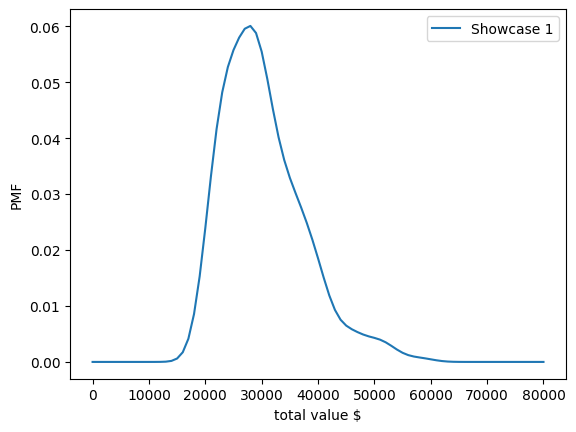

In [4]:
import numpy as np
import pandas as pd

qs = np.linspace(0, 80000, 81) # 1000 단위로 나눔, 가능한 가격의 범위

prior1 = kde_from_sample(df['Showcase 1'], qs)
prior1.plot(label = 'Showcase 1')
plt_default('total value $')

### 문제 9-1 

이 함수를 사용해서 진열대 2번에 대한 사전분포를 나타내는 Pmf를 만들고, 이를 그래프로 그려보자. 

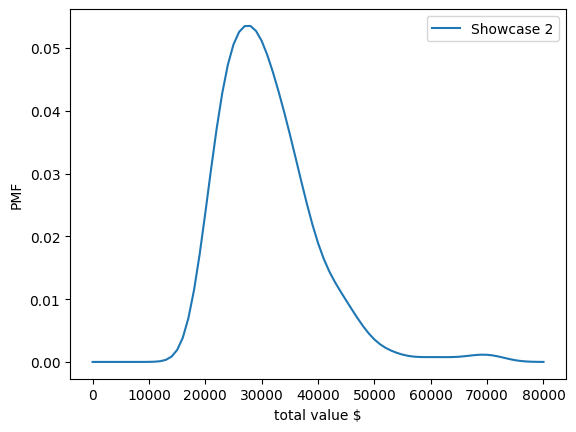

In [5]:
prior2 = kde_from_sample(df['Showcase 2'], qs)
prior2.plot(label = 'Showcase 2')
plt_default('total value $')

## 9.4 오차분포

- 사전분포를 갱신하려면, 우선 다음 질문에 답할 수 있어야 한다. 
  
  - 어떤 데이터를 고려해야 하며 어떻게 정량화해야 할까요? (= 어떤 데이터를 값으로 사용해야 할까?)
  
  - 가능도함수를 계산할 수 있나? 말인 즉 각 가설금액에 대해 데이터의 조건부 우도를 계산할 수 있나?

- 또 이런 질문에 대답하기 위해서, 주어진 오차에 따라 금액을 추측하는 도구 형태로 각 참가자를 모델링할 것이다. 

- 이 모델에서는 참가자가 각 상품을 보고 각각의 상품에 대한 값을 구하고 이 값을 더한다. 이 총 값을 guess 라고 하자.

- 그렇다면 우리가 답해야 하는 질문은 다음과 같다.

- "만약 실제 가격이 price라면, 참가자의 추측이 guess가 되도록하는 가능도는 어떻게 되는가?" 

- $P(H|D) = \frac{P(H)P(D|H)}{P(D)}$

- $P(실제 가격이 price인 사건|참가자가 guess라고 예측하는 사건) = \frac{실제 가격이 price인 사건 \times 참가자가 guess라고 예측하는 사건 | 실제 가격이 price인 사건}{참가자가 guess라고 예측하는 사건}$

- 마찬가지로 error = guess - price 로 정의하는 경우 다음과 같은 질문도 가능하다. "참가자의 추측이 error만큼 빗나갈 가능도는 얼마인가?"

- 이 질문에 답하기 위해 기존의 기록을 다시 사용하자. 데이터셋에서 각 진열대 별로, 참가자가 입찰한 금액과 실제 금액간의 차이를 살펴보자. 

- 또한 차이의 분포를 시각화하기 위해, KDE를 다시 사용한다. 

In [6]:
sample_diff1 = df['Bid 1'] - df['Showcase 1']
sample_diff2 = df['Bid 2'] - df['Showcase 2']

print(sample_diff1.max(), sample_diff1.min())
print(sample_diff2.max(), sample_diff2.min())

14187.0 -31374.0
25839.0 -43628.0


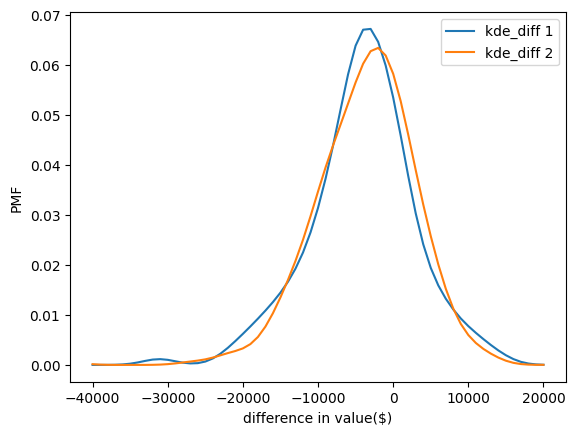

In [7]:
qs = np.linspace(-40000, 20000, 61)
kde_diff1 = kde_from_sample(sample_diff1, qs)
kde_diff2 = kde_from_sample(sample_diff2, qs)

kde_diff1.plot(label = 'kde_diff 1')
kde_diff2.plot(label = 'kde_diff 2')
plt_default('difference in value($)')

In [8]:
kde_diff2.mean()

-3650.370624996077

전체적으로 금액보다 크게 예측하기 보다는 작게 예측하는 경우가 훨씬 많아 보인다. 이는 충분히 합리적이다.

금액을 높게 예측할 경우 무조건 탈락이므로, 아마도 참가자들은 의도적으로 보다 낮은 금액을 불렀을 것이다. 

예를 들어 참가자가 40000$ 라고 진열대 위의 물건을 예측했다고 해도 10% 낮춘 36000$를 부를 가능성이 크다는 것이다. 

이 분포는 정규분포 형태로 모델링되어서 평균과 표준편차로 요약이 가능하다. 

In [9]:
mean_diff1 = sample_diff1.mean()
std_diff1 = sample_diff1.std()

print(mean_diff1, std_diff1)

-4116.3961661341855 6899.909806377117


이 차이를 사용해서 참가자의 오차에 대한 분포를 모델링할 수 있다. 실제 참가자들이 처음에 추측한 값을 실제로 알 방도는 없기 때문에, 이 단계는 다소 이상해보일 수 있다. 

우리가 아는 것은 참가자들이 직접 제시한 금액뿐이다. 그래서 여기에 몇 가지 가정을 추가한다.

- 참가자들이 전략적으로 다소 낮은 입찰가를 불렀다고 가정한다. 그리고 평균적으로 실제 추측값은 평균적으로 정확했다고 하자. 즉 오차의 평균은 0일 것이다. 
- 하지만 차이의 분포는 오차의 분포와 동일했다고 하자. 따라서 이 차이의 표준편차는 오차의 표준편차와 동일할 것이다. 

이 가정에 따라 0과 std_diff1을 매개변수로 사용하여 정규분포를 만들 것이다. 사이파이에는 주어진 평균과 표준편차를 따르는 정규분포 객체, norm이 있다.

In [10]:
from scipy.stats import norm

error_dist1 = norm(0, std_diff1)

결과값은 정규분포의 확률밀도함수를 구하는 pdf 객체다. 

예를 들어 1번 참가자의 오차의 분포에 따른 error = -100 의 확률밀도(density)는 다음과 같다. 

In [11]:
error_dist1.pdf(-100)

5.781240564008691e-05

확률밀도는 확률이 아니므로 숫자 그 자체에는 큰 의미가 없다. 하지만 이는 확률에 비례하므로, likelihood처럼 쓸 수 있다. 이에 대해서는 다음 절에서 살펴보자.

## 9.5 Update

당신이 1번 참가자라고 해보자. 당신은 지금 진열대에서 물건들을 보고 총 가격이 $23,000 이라고 예측했다. 

추측값으로부터 사전분포의 각 가설값을 뺴보자. 그러면 각 가설값에 대한 오차가 나온다. 

In [12]:
guess1 = 23000
error1 = guess1 - prior1.qs

이제 앞서 말한 대로 추정오차 error1 은 정규분포 error_dist1 을 따른다고 가정하자. 

이 가정하에 각 가설에 대한 오차의 가능도를 구할 수 있다. 

가능도의 배열 형태의 결과값을 사용해서 사전분포를 갱신한다. 

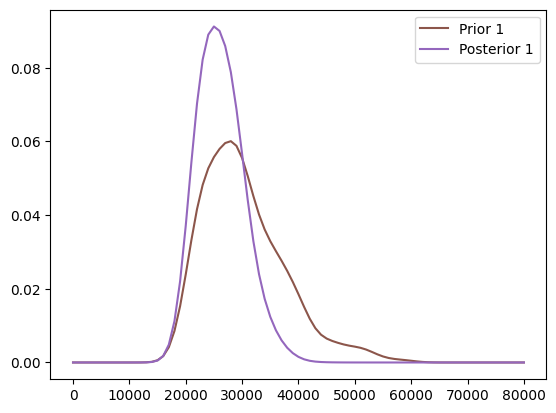

In [13]:
import matplotlib.pyplot as plt

likelihood1 = error_dist1.pdf(error1)
posterior1 = prior1 * likelihood1
posterior1.normalize()


prior1.plot(color='C5', label='Prior 1')
posterior1.plot(color='C4', label='Posterior 1')
plt.legend()
plt.show()

당신의 초기 추측값(initial guess)은 해당 값 범위에서 가장 낮은 곳이므로 사후분포는 왼쪽으로 이동했다. 

사후분포값의 평균값을 통해 얼마나 많이 이동했는 지를 확인할 수 있다. 

In [14]:
prior1.mean(), posterior1.mean()

(30299.488817891375, 26192.024002392536)

물건들을 보기 전에는 진열대 상품 가격이 $30,000 에 가깝다고 생각했으나, $23,000 이라고 추측한 후 사전분포를 갱신했다. 이제 사후분포를 통해 실제 값은 $26,000 이라고 예상하게 되었다. 


### 문제 9-2

- 당신이 2번 참가자라고 하자. 진열대를 보고 총 가격이 $38,000 이라고 추측했다. 
- diff2를 사용해서 추정 오차의 분포를 나타내는 정규분포를 만들어보자. 
- 각 실제 금액의 추측값에 대한 가능도를 구하고 이를 사용해서 prior2를 갱신하자. 
- 사후분포의 그래프를 그리고 사후분포의 평균을 구하자. 
- 사전분포와 추측값을 기반으로, 진열대 위의 물건의 실제 가격은 얼마일 것이라고 예측할 수 있을까?

In [15]:
# sample_diff2 의 표준편차
std_diff2 = sample_diff2.std()
# 추측
guess2 = 38000
# 추측오차의 가능한 값의 범위
error2 = guess2 - prior2.qs 
# diff2를 사용한 추정오차의 정규분포
error_dist2 = norm(0, std_diff2)
# likelihood
likelihood2 = error_dist2.pdf(error2)
# posterior
posterior2 = prior2 * likelihood2
posterior2.normalize()

2.697812321910702e-05

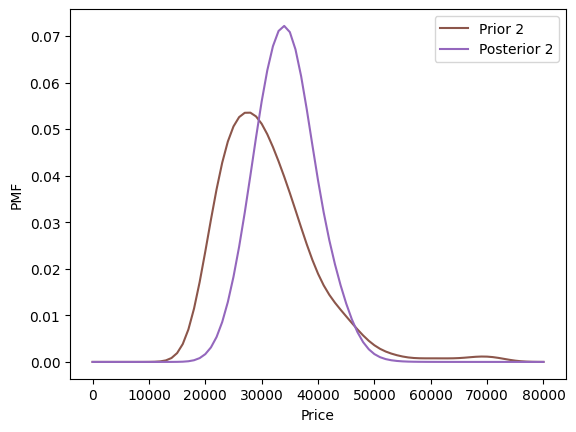

In [16]:
prior2.plot(color='C5', label='Prior 2')
posterior2.plot(color='C4', label='Posterior 2')
plt.ylabel("PMF")
plt.xlabel("Price")
plt.legend()
plt.show()

In [17]:
prior2.mean(), posterior2.mean()

(31047.62371912251, 34305.20161642469)

## 9.6 우승확률

각 선수별 사후분포를 구했으니, 이제 전략에 대해 고민해보자. 

- 우선 1번 참가자의 관점에서 2번 참가자가 실제 가격보다 높게 입찰할 확률을 구해보자. 
- 간단히 하기 위해 진열대 물건의 가격은 무시하고 이전 참가자의 기록만을 사용한다.
- 다음 함수는 이전 입찰 수열을 취해서 입찰가가 높을 확률을 반환한다. 

In [18]:
def prob_overbid(sample_diff):
    """높게 입찰할 확률을 구함"""
    return np.mean(sample_diff > 0)

다음은 2번 참가자가 overbid 할 확률이다.

In [19]:
prob_overbid(sample_diff2)

0.29073482428115016

- 여기서 1번 참가자가 $5,000 낮은 가격으로 입찰했다고 하자. 이 때 2번 참가자가 더 낮게 입찰했을 확률은 얼마일까? 

- 다음 함수는 이전의 성과를 사용해서 참가자가 주어진 금액 차이인 diff보다 더 낮게 입찰했을 확률을 추정한다. 

In [20]:
def prob_worse_than(diff, sample_diff):
    """주어진 diff보다 상대방의 diff가 더 낮을 확률"""
    return np.mean(sample_diff < diff)

In [21]:
prob_worse_than(-5000, sample_diff2)

0.38338658146964855

In [22]:
np.mean(sample_diff2 > -5000)

0.6166134185303515

이를 조합해서 주어진 실제 가격대비 입찰금액을 사용해 1번 참가자가 이길 확률을 구하는 함수를 만들 수 있다.

In [23]:
def compute_winning_rate(diff, sample_diff):
    """(상대의)차이값이 주어졌을 때 이길 확률"""
    # 실제가격을 초과했을 경우 무조건 진다.
    if diff > 0 :
        return 0
    # 상대방이 초과해서 입찰한 경우 이긴다.
    p1 = prob_overbid(sample_diff)
    # 상대방의 입찰이 더 안 좋은 경우 이긴다.
    p2 = prob_worse_than(diff, sample_diff)
    # p1 과 p2는 상호배제관계이므로 둘을 더할 수 있다
    return p1 + p2

In [24]:
compute_winning_rate(-5000, sample_diff2)

0.6741214057507987

그러면 가능한 금액 차이 범위 내에서 이길 확률을 살펴보자.

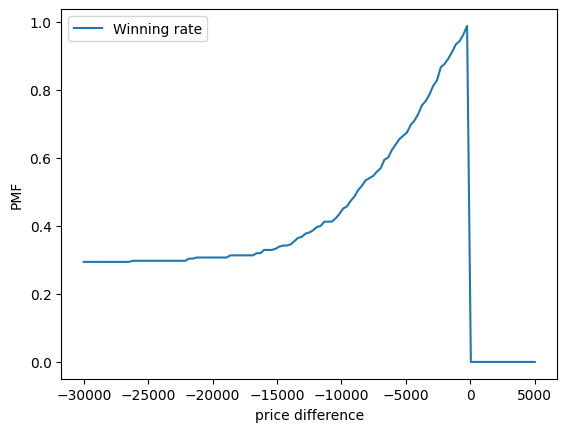

In [25]:
# 그래프

xs = np.linspace(-30000, 5000, 121)
ys = [compute_winning_rate(x, sample_diff2) for x in xs]

plt.plot(xs,ys,label = 'Winning rate')
plt.xlabel('price difference')
plt.ylabel('PMF')
plt.legend()
plt.show()

### 문제 9.3

동일한 분석을 2번 참가자 관점에서 실행해보자. 1번 참가자의 차이 값을 샘플로 사용해서 다음을 구해보자. 

1. 1번 참가자가 높은 금액을 입찰할 확률
2. 1번 참가자가 $5,000 이상으로 차이가 나는 낮은 금액을 입찰할 확률
3. $5,000 낮게 입찰한 경우 2번 참가자가 이길 확률

In [26]:
np.mean(0 < sample_diff1)

0.24600638977635783

In [27]:
np.mean(-5000 > sample_diff1)

0.3993610223642173

In [28]:
compute_winning_rate(-5000, sample_diff1)

0.6453674121405751

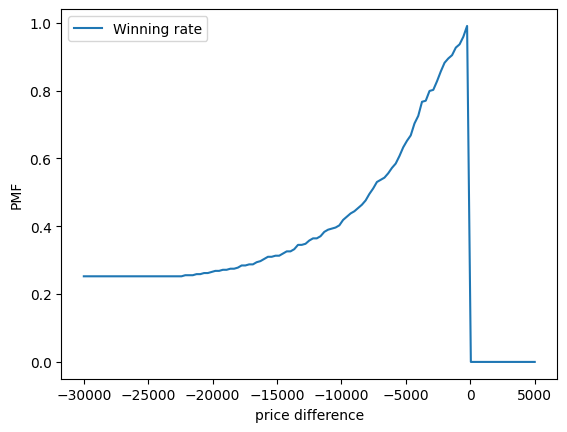

In [29]:
# 그래프

xs = np.linspace(-30000, 5000, 121)
ys = [compute_winning_rate(x, sample_diff1) for x in xs]

plt.plot(xs,ys,label = 'Winning rate')
plt.xlabel('price difference')
plt.ylabel('PMF')
plt.legend()
plt.show()

## 9.7 의사결정분석

앞서 특정 금액만큼 낮게 입찰한 경우 이길 확률을 구했다. 

실제로 참가자들은 실제 진열대 물건들의 가격을 모르므로 그들이 얼마만큼 낮게 입찰했는지를 알 수 없다. 

하지만 참가자의 실제 금액에 대한 믿음을 사후확률분포로 나타낼 수 있고, 이를 사용해서 주어진 입찰가로 이길 확률을 추정해볼 수 있다.

다음 함수는 가능한 입찰가, 실제 가격에 대한 사후확률분포, 상대방의 금액 차이 샘플을 사용한다. 

그리고 반복적으로 사후분포의 가설 가격을 살펴보면서, 각 가격에 대해서 다음을 실행한다. 

1. 입찰가와 가설 가격의 차이를 구한다.
2. 주어진 차이 값으로 참가자가 이길 확률을 구한다.
3. 확률의 가중치 합을 구한다. 이 때 가중치는 사후분포에서의 확률값이다. 

In [30]:
def total_prob_win(bid, posterior, sample_diff):
    """주어진 입찰가로 이길 총확률을 구함
    bid: 입찰가, posterior: 진열대 물건 값의 Pmf, sample_diff: 상대방의 값 차이의 샘플
    returns: 이길 확률
    """
    total = 0
    for price, prob in posterior.items(): # qs, ps
        diff = bid - price
        total += prob * compute_winning_rate(diff, sample_diff)
    return total

이 반복문은 전체확률의 법칙을 구현했다.

$$P(win) = \sum_{price}P(price)P(win|price)$$

다음은 1번 참가자가 $25,000을 입찰했고 사후분포 posterior1을 사용할 때 이길 확률이다.

In [31]:
total_prob_win(25000, posterior=posterior1, sample_diff= sample_diff2)

0.4842210945439812

이를 가능한 입찰가 수열에 대해 반복적으로 실행해서 각 참가자가 이길 최종 확률을 구할 수 있다.

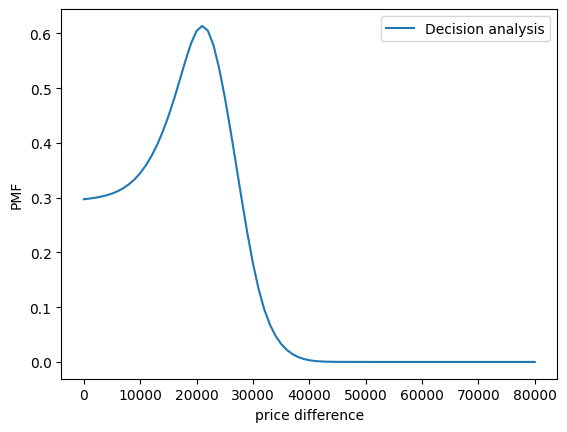

In [32]:
bids = posterior1.qs

probs = [total_prob_win(bid, posterior1, sample_diff2) for bid in bids]

prob_win_series = pd.Series(probs, index = bids)
prob_win_series.plot(label = 'Decision analysis')
plt.xlabel('price difference')
plt.ylabel('PMF')
plt.legend()
plt.show()

In [33]:
# 1번 참가자가 이길 확률이 최대인 입찰가

prob_win_series.idxmax()

21000.0

In [34]:
# 위의 확률
prob_win_series.max()

0.6136807192359474

당신이 추측한 금액은 $23,000 이었다. 이 추측을 사용해서 사후분포를 구하면, 사후분포의 평균은 약 $26,000 이다. 하지만 이길 확률을 가장 높이는 입찰가는 $21,000 이다.

### 문제 9.4 

- 동일한 분석을 2번 참가자에 대해 해보자.

동일한 분석의 요구조건 정리

- 참가자의 실제 금액에 대한 믿음을 사후확률분포로 나타낼 수 있고, 이를 사용해서 주어진 입찰가로 이길 확률을 추정
    1. 입찰가와 가설 가격의 차이를 구한다.
    2. 주어진 차이 값으로 참가자가 이길 확률을 구한다.
    3. 확률의 가중치 합을 구한다. 이 때 가중치는 사후분포에서의 확률값이다. 

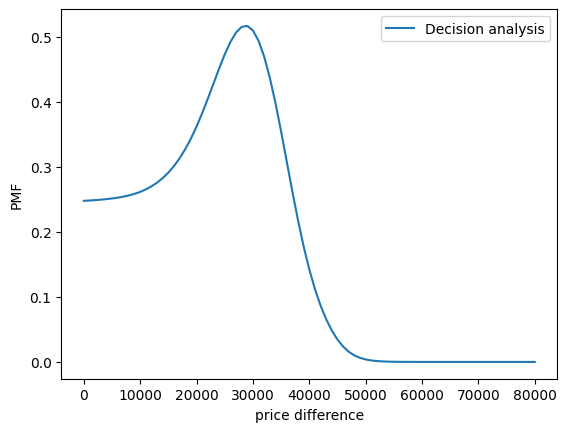

In [35]:
bids = posterior2.qs
probs = [total_prob_win(bid=bid,posterior=posterior2,sample_diff=sample_diff1) for bid in bids]
prob_win_series = pd.Series(probs, index = bids)
prob_win_series.plot(label = 'Decision analysis')
plt.xlabel('price difference')
plt.ylabel('PMF')
plt.legend()
plt.show()

In [36]:
# 2번 참가자가 이길 확률이 최대인 입찰가

prob_win_series.idxmax()

29000.0

In [37]:
# 위의 확률
prob_win_series.max()

0.5171370053364229

## 9.8 예상수익 최대화

앞 절에서는 이길 확률을 최대화하는 입찰가를 구했다. 이게 목표라면, 우리가 구한 입찰이 최적값이다. 

하지만 이기는 것이 전부는 아니다. 입찰가가 실제가보다 $250이나 그 이하의 값 차이로 적다면, 당신은 두 진열대 모두에 대해서 이길 수 있다. 따라서 입찰가를 조금 늘리는 것도 좋은 전략이 될 수 있다.

입찰가가 커지면 실제 값보다 초과한 입찰로 질 확률도 높아지지만, 양쪽의 진열대에 대해서 모두 이길 확률 역시 높아진다. 



이게 어떤 구조로 돌아가는지 살펴보자. 다음 함수는 주어진 입찰가와 실제 금액, 상대의 오차의 샘플을 사용해서 당신이 평균적으로 얼마를 받을 수 있을 지를 구한다. 

In [38]:
def compute_gain(bid, price, sample_diff):
    """입찰가와 실제 금액을 사용해 예상 수익을 구한다."""
    diff = bid - price
    prob = compute_winning_rate(diff, sample_diff)
    # 250달러 이내의 차이로 이기면, 양쪽 모두 이긴다.
    if -250 <= diff <= 0:
        return 2 * price * prob
    else:
        return price * prob

예를 들어, 실제 금액이 $35,000이고 당신이 $30,000을 걸었다면 질 확률, 한 쪽만 이길 확률, 양쪽 모두 이길 확률을 계산했을 때 평균 $23,600을 받을 수 있다.

In [39]:
compute_gain(30000,35000,sample_diff2)

23594.249201277955

현실적으로는 우리가 실제 금액을 알 수 없지만, 우리에게는 이에 대해서 알고 있는 것을 나타내는 사후확률분포가 있다. 

사후확률분포의 확률과 가격을 평균 내어, 특정 입찰가에 대한 예상 수익을 구할 수 있다.

이 때 __'예상'은 가능한 진열대의 금액별로 확률 가중치를 주어 구한 평균이라는 뜻이다.__ 

In [40]:
def expected_gain(bid, posterior, sample_diff):
    """주어진 입찰가에 대한 예상수익을 구함"""
    total = 0
    for price, prob in posterior.items():
        total += prob * compute_gain(bid, price, sample_diff)
    return total

앞서 구한 사후확률을 사용했을 때, $23,000으로 값을 추측해서 $21,000을 입찰했을 때의 예상 수익은 $16,900 이다.

In [41]:
expected_gain(21000, posterior1, sample_diff=sample_diff2)

16923.59933856512

하지만 좀 더 잘할 수는 없을까?

입찰가의 범위에 대해 반복적으로 탐색해서 최대 예상 수익을 내보자.

In [42]:
bids = posterior1.qs

gains = [expected_gain(bid, posterior1, sample_diff2) for bid in bids]

expected_gain_series = pd.Series(gains, index = bids)

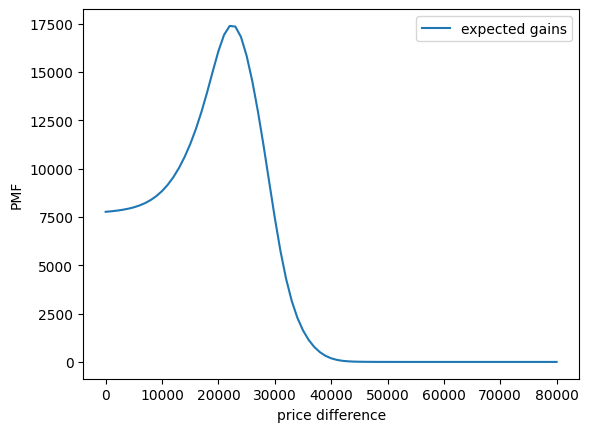

In [43]:
expected_gain_series.plot(label = 'expected gains')
plt.xlabel('price difference')
plt.ylabel('PMF')
plt.legend()
plt.show()

In [44]:
expected_gain_series.idxmax()

22000.0

In [45]:
expected_gain_series.max()

17384.899584430797

초반에 추측한 금액은 $23,000 이었다. 우승확률을 가장 높이는 입찰가는 $21,000 이었다. 그리고 최대 예상 수익을 내는 금액은 $22,000 이다.

## 9.9 요약

이 장에서는 많은 내용을 다뤘다. 다음 단계대로 다시 한 번 되짚어보자.

1. 처음에는 KDE와 기존 프로그램에서의 데이터를 사용해서 진열대 가격의 __사전분포를 추정__ 했다.
2. 그리고 __기존 프로그램의 입찰가를 사용__ 해서 __정규분포로 오차분포 모델__ 을 만들었다.
3. __오차분포를 사용한 베이지안 갱신__ 으로 데이터의 __가능도를 구했다.__
4. 진열대 금액의 사후분포를 통해 각 가능한 입찰가별 이길 확률을 구하고, 이길 확률을 최대로 만드는 입찰가를 정의했다.
5. 마지막으로 이길 확률을 사용해서 각 가능한 입찰가별 예상 수익을 구하고, 예상 수익을 최대로 만드는 입찰가를 정의했다. 

- 이 예제는 무엇을 최적화하고 있는지 명시하지 않고 '최적'이라는 단어를 사용하는 것이 위험하다는 것을 알려준다. 
- 이길 확률을 최대로 하는 입찰가와 예상 수익을 최대로 하는 입찰가는 일반적으로 같지 않다.

## 9.10 Discussion

사람들이 베이지안 추정에 대한 장단점을 말할 때, '빈도주의 Frequentist'라고 불리는 전통적 방법과 비교해서 많은 경우 베이지안 방식과 빈도주의 방식의 결과가 동일하다고 주장한다.

아무래도 이 주장에는 오해가 있는 것 같다. 베이지안과 빈도주의 방법에는 결과 종류에서 차이가 있다. 

- 빈도주의 방식의 결과는 보통 (여러 조건 중 하나에 따른)최상의 추정치인 단일값이거나 추정값의 정밀도를 수치화한 구간이다. 
- 베이지안 방식의 결과는 모든 가능한 결과와 각 결과의 확률로 나타내는 사후분포다. 

__물론 사후분포를 사용하여 '최상의' 추정치를 선택하거나 구간을 구할 수 있다. 그리고 이 경우 결과는 빈도주의에서의 추정치와 같을 수 있다.__

하지만 이렇게 하면 유용한 정보를 잃을 수 있고, 사후분포는 단일값이나 구간보다 더욱 유용하다는 베이지안 방식의 기본적인 장점이 사라질 수 있다. 

이 장의 예제에서 이 점에 대해 살펴보았다. 전체 사후분포를 사용해서 가장 높은 입찰가를 구할 수 있고, 수익을 계산 규칙이 복잡하기는 하지만(심지어 비선형적이다) 규칙 예쌍 수익을 최대로 하는 입찰가를 구할 수 있다.

값이 아무리 '최적'이라고 해도 단일 추정값이나 구간값으로는 이런 것을 할 수 없다. 

__일반적으로 빈도주의 추정값은 의사결정을 이끌 정보를 거의 주지 못한다.__

만약 누군가가 베이지안과 빈도주의 방식의 결과가 동일하다고 하는 말을 듣는다면, 그 사람들은 베이지안 방법을 이해하지 못했다고 말해도 된다.



## 9.11 연습문제


### 문제 9.6 

지하철시간은 예측하기 어려워서, 가능한 한 사무실에서 일찍 퇴근하면 15분을 기다려서 통근 열차를 탈 수 있다.

지하철역에 도착하면 플랫폼에는 보통 10명 정도의 사람들이 지하철을 기다리고 있다. 이보다 적은 경우는 기차를 방금 놓쳤다고 생각하고, 평소보다 조금 더 기다려야 할 것이라고 예상할 수 있다.

만약 이보다 사람이 많다면 곧 기차가 온다고 생각한다. 

하지만 플랫폼의 승객수가 10명보다 훨씬 더 많다면, 무언가 잘못되어 더 오래 기다려야 하므로 택시를 탄다. 

베이지안 의사결정분석을 사용해서 직관적으로 했던 분석을 수치화할 수 있다. 

플랫폼의 승객수가 주어졌을 때, 몇 분 정도를 더 기다려야 할 거라고 예상되는가? 

포기하고 택시를 타러 가야하는 경우는 어떤 경우일까?

1. n 분, 시간에 대한 이야기를 하고 있으므로 포아송분포 ,감마분포, 지수분포를 활용해야 할까?
2. 승객수를 입력으로 받는다. lambda가 10인 포아송분포일까?
3. 

#### 해설

- 분석을 시작하기 전에 몇 가지 모델링 결정을 내려야 합니다. 먼저, 승객 도착을 푸아송 과정으로 처리할 것입니다. 즉, 승객이 언제든 똑같이 도착할 가능성이 있고 분당 승객 수로 측정되는 λ의 속도로 도착한다고 가정합니다. 저는 짧은 시간 동안 매일 같은 시간에 승객을 관찰하기 때문에 λ가 일정하다고 가정합니다.

- 반면에 기차의 도착 과정은 푸아송이 아닙니다. 보스턴행 열차는 피크 시간대에는 7~8분 간격으로 종점(알레위프 역)에서 출발해야 하지만, 켄달 스퀘어에 도착할 때까지 열차 간격은 3분에서 12분 사이로 다양합니다.
- 열차 간 간격에 대한 데이터를 수집하기 위해 MBTA에서 실시간 데이터를 다운로드하고, 켄달 광장에 도착하는 남행 열차를 선택한 다음, 도착 시간을 데이터베이스에 기록하는 스크립트를 작성했습니다. 평일 오후 4시부터 오후 6시까지 5일 동안 스크립트를 실행하여 하루에 약 15건의 도착 시간을 기록했습니다. 그런 다음 연속적으로 도착하는 시간 사이의 간격을 계산했습니다. 다음은 제가 기록한 간격 시간(초)입니다.

```python
observed_gap_times = [
    428.0, 705.0, 407.0, 465.0, 433.0, 425.0, 204.0, 506.0, 143.0, 351.0, 
    450.0, 598.0, 464.0, 749.0, 341.0, 586.0, 754.0, 256.0, 378.0, 435.0, 
    176.0, 405.0, 360.0, 519.0, 648.0, 374.0, 483.0, 537.0, 578.0, 534.0, 
    577.0, 619.0, 538.0, 331.0, 186.0, 629.0, 193.0, 360.0, 660.0, 484.0, 
    512.0, 315.0, 457.0, 404.0, 740.0, 388.0, 357.0, 485.0, 567.0, 160.0, 
    428.0, 387.0, 901.0, 187.0, 622.0, 616.0, 585.0, 474.0, 442.0, 499.0, 
    437.0, 620.0, 351.0, 286.0, 373.0, 232.0, 393.0, 745.0, 636.0, 758.0,
]
```

분 단위로 변환하고 kde_from_sample을 사용하여 분포를 추정해 보겠습니다.

In [46]:
# 모수를 사용해 사전 분포를 추정

observed_gap_times = [
    428.0, 705.0, 407.0, 465.0, 433.0, 425.0, 204.0, 506.0, 143.0, 351.0, 
    450.0, 598.0, 464.0, 749.0, 341.0, 586.0, 754.0, 256.0, 378.0, 435.0, 
    176.0, 405.0, 360.0, 519.0, 648.0, 374.0, 483.0, 537.0, 578.0, 534.0, 
    577.0, 619.0, 538.0, 331.0, 186.0, 629.0, 193.0, 360.0, 660.0, 484.0, 
    512.0, 315.0, 457.0, 404.0, 740.0, 388.0, 357.0, 485.0, 567.0, 160.0, 
    428.0, 387.0, 901.0, 187.0, 622.0, 616.0, 585.0, 474.0, 442.0, 499.0, 
    437.0, 620.0, 351.0, 286.0, 373.0, 232.0, 393.0, 745.0, 636.0, 758.0,
]

zs = np.array(observed_gap_times)/60 # broadcasting을 위해서 np.array화 -> 분으로 변환
qs = np.linspace(0,20,101) # 0~ 20 분 이내의 시간


pmf_z = kde_from_sample(zs, qs) # 기차간 도착 간격 분포


## The Update

At this point we have an estimate for the distribution of time between trains.
Now let's suppose I arrive at the station and see 10 passengers on the platform.
What distribution of wait times should I expect?

We'll answer this question in two steps.

* First, we'll derive the distribution of gap times as observed by a random arrival (me).

* Then we'll derive the distribution of wait times, conditioned on the number of passengers.

When I arrive at the station, I am more likely to arrive during a long gap than a short one.
In fact, the probability that I arrive during any interval is proportional to its duration.

If we think of `pmf_z` as the prior distribution of gap time, we can do a Bayesian update to compute the posterior.
The likelihood of my arrival during each gap is the duration of the gap:


이 시점에서 열차 사이의 시간 분포를 추정할 수 있습니다.
이제 역에 도착했는데 플랫폼에 10명의 승객이 있다고 가정해 보겠습니다.
어떤 대기 시간 분포를 예상해야 할까요?

이 질문에 대한 답은 두 단계로 나눠서 드리겠습니다.

* 먼저, 무작위 도착자(나)가 관찰한 대기 시간 분포를 도출합니다.

* 그런 다음 승객 수에 따라 대기 시간 분포를 도출합니다.

제가 역에 도착하면 짧은 간격보다 긴 간격에 도착할 확률이 더 높습니다.
실제로 내가 어떤 간격에 도착할 확률은 그 간격의 길이에 비례합니다.

- 주석: 이 말은 내가 어떤 간격에 도착할 확률은 len(t) * p(x) 라는 뜻. 근데 도착확률은 정확히 모르므로 len(t)로 대체하겠다는 말이다. 

간격 시간의 사전 분포를 `pmf_z`라고 생각하면 베이지안 업데이트를 수행하여 사후 분포를 계산할 수 있습니다.
각 간격 동안 내가 도착할 확률은 간격의 지속 시간입니다:

In [49]:
pmf_z

,probs
0.0,3.383467e-04
0.2,4.995788e-04
0.4,7.186512e-04
0.6,1.007339e-03
0.8,1.376123e-03
...,...
19.2,1.654807e-06
19.4,8.862266e-07
19.6,4.609887e-07
19.8,2.329062e-07


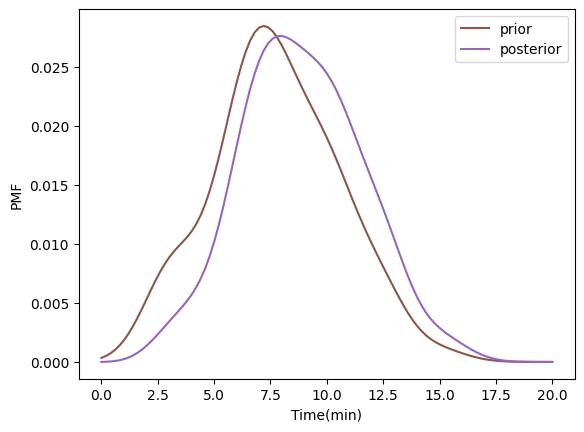

In [47]:
likelihood = pmf_z.qs # 어떤 간격에 도착할 확률 = 그 간격의 지속시간 

posterior_z = pmf_z * pmf_z.qs
posterior_z.normalize()

pmf_z.plot(label = 'prior', color = 'C5')
posterior_z.plot(label = 'posterior', color = 'C4')

plt_default('Time(min)')

In [48]:
likelihood

array([ 0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2,  1.4,  1.6,  1.8,  2. ,
        2.2,  2.4,  2.6,  2.8,  3. ,  3.2,  3.4,  3.6,  3.8,  4. ,  4.2,
        4.4,  4.6,  4.8,  5. ,  5.2,  5.4,  5.6,  5.8,  6. ,  6.2,  6.4,
        6.6,  6.8,  7. ,  7.2,  7.4,  7.6,  7.8,  8. ,  8.2,  8.4,  8.6,
        8.8,  9. ,  9.2,  9.4,  9.6,  9.8, 10. , 10.2, 10.4, 10.6, 10.8,
       11. , 11.2, 11.4, 11.6, 11.8, 12. , 12.2, 12.4, 12.6, 12.8, 13. ,
       13.2, 13.4, 13.6, 13.8, 14. , 14.2, 14.4, 14.6, 14.8, 15. , 15.2,
       15.4, 15.6, 15.8, 16. , 16.2, 16.4, 16.6, 16.8, 17. , 17.2, 17.4,
       17.6, 17.8, 18. , 18.2, 18.4, 18.6, 18.8, 19. , 19.2, 19.4, 19.6,
       19.8, 20. ])

나는 일반적으로 더 오랜 대기 시간을 관측하기에, 분포가 오른쪽에 치우쳐져 있습니다. 

사전평균은 7.8 분이었지만, 사후평균은 8.9분이 되었습니다. 

이러한 변화는 'inspection paradox"(검사의 역설)의 한 예시입니다. 

여담이지만, 레드 라인 시간표에 따르면 피크 시간대에는 열차가 9분 간격으로 운행됩니다. 이는 사후 평균에 가깝지만 사전 평균보다는 높습니다. MBTA 담당자와 이메일을 주고받은 결과, 열차 간 배차 간격은 변동성을 고려하기 위해 의도적으로 보수적으로 잡았다는 사실을 확인했습니다.


Elapsed time, 즉 x라고 하는 경과 시간은 이전 열차의 도착과 승객의 도착 사이의 시간입니다. Wait time, 대기 시간 y는 승객이 도착한 후 다음 열차가 도착할 때 까지의 시간입니다. 

그럼 이렇게 수식을 작성할 수 있겠군요.

```python
z = x + y
```

z의 분포가 주어지면 x의 분포를 계산할 수 있습니다. 간단한 경우부터 시작해서 일반화해 보겠습니다. 기차 사이의 간격이 동일한 확률로 5분 또는 10분이라고 가정해 보겠습니다.

무작위 시간에 도착하면 1/3 확률로 5분 간격에 도착하거나 2/3 확률로 10분 간격에 도착합니다.

5분 간격으로 도착하는 경우 x는 0에서 5분까지 균일합니다. 10분 간격으로 도착하면 x는 0에서 10까지 균일합니다. 따라서 대기 시간 분포는 두 개의 균등 분포에 가중치를 부여한 혼합 분포입니다.

더 일반적으로, z의 후행 분포가 있다면 균등 분포의 혼합을 통해 x의 분포를 계산할 수 있습니다. 다음 함수를 사용하여 균등 분포를 만들겠습니다.

In [ ]:
def make_elapsed_dist(gap, qs):
    qs = qs[qs<=gap]
    n = len(qs)
    return Pmf(1/n, qs)